In [1]:
# Производится анализ стратегий и подбирается наиболее удачный портфель стратегий по характеристикам:
#  - минимальная просадка
#  - прибыль/минимальная просадка   ЭТОТ параметр ЛУЧШЕ !!!
#  - наименее коррелируемые
# Перебеираются все наборы и все комбинации стратегий со всеми парамтерами.
# Расчитывается коэффициент корреляции всех стратегий между собой.
# Стратегии прогоняются по минуткам с микровходом
# Есть подбор самых наименее коррелируемых стратегий по заданному количеству. с перебором всех вариантов сочетаний.

# v2 ! Добавим нормирование стратегий по просадке (вариант по максимальному профиту не логичен,
#     т.к. нас интересует в первую очередь минимизация максимальной просадки) 
#     и после этого только будет перебор стратегий для выбора наилучшей комбинации

# v3 ! Добавим мультикотировочность ! Пока только для 'e_kama_sm'

# v4 ! Переход на новый тип записи стратегий "имя стратегии" "параметр 1" "параметр 2" "параметр 3"

# v5 ! При мультикотировочности, анализируем исходя из относительной волатильности каждого актива.

# v6 ! Тоже что и v5, только относительная волатильность актива считается через ATR а не через DEV  более точно и грамотно
#      ещё оптимизирован перебор комбинаций стратегий, сделано сочетание до 3 до 4-х и т.д. чтобы больше протестить !
#      Да ещё и оказалось что считало неправильно в v5 ! внутри цикла не того были расчеты, передвинул ! в v6 и в v5

import math
import os
import pandas_datareader as pdr
import datetime 
import time
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook   # Это для красивого прогресс бара
from itertools import *          # Это для сочетаний групп стратегий,, для расчета обще корреляции
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from my_module_anal import *
# from my_module import *

In [2]:
# from importlib import reload
# reload(my_module.py) # обновление без рестарта кернела
# import importlib
# importlib.reload(my_module)

In [3]:
# 0.
# Считаем котировки

# Считаем котировки Si
curr_m0 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m/SPFB.Si_160501_170501.csv', sep=';')) # Большие суперданные 2016-2017
curr_m  = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m/1m_SPFB.Si_180501_200507.csv', sep=';')) # Большие суперданные 2019-2020
curr_m2 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m/1m_SPFB.Si_180501_190501.csv', sep=';')) # Большие суперданные 2018-2019
curr_m3 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m/1m_SPFB.Si_170501_180501.csv', sep=';')) # Большие суперданные 2017-2018
curr_m4 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m/SPFB.Si_200501_210501.csv', sep=';')) # Большие суперданные 2020-2021
curr_m5 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m/SPFB.Si_210501_220501.csv', sep=';')) # Большие суперданные 2021-2022

# Объдиним в одну пачку Через жопу, через xuy, ну и ладно
xuy = curr_m.merge(curr_m2, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m3, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m4, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m0, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m5, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy.sort_values(by = ['timestamp'],ascending=True, inplace=True)
xuy.reset_index(inplace=True,drop=True)
Si = xuy

# Считаем котировки RTS
curr_m0 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m/SPFB.RTS_160501_170501.csv', sep=';')) # Большие суперданные 2016-2017
curr_m  = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m/1m_SPFB.RTS_190501_200501.csv', sep=',')) # Большие суперданные 2019-2020
curr_m2 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m/1m_SPFB.RTS_180501_190501.csv', sep=',')) # Большие суперданные 2018-2019
curr_m3 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m/1m_SPFB.RTS_170501_180501.csv', sep=',')) # Большие суперданные 2017-2018
curr_m4 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m/SPFB.RTS_200501_210501.csv', sep=';')) # Большие суперданные 2020-2021
curr_m5 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m/SPFB.RTS_210501_220501.csv', sep=';')) # Большие суперданные 2020-2021

# Объдиним в одну пачку Через жопу, через xuy, ну и ладно
xuy = curr_m.merge(curr_m2, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m3, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m4, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m0, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m5, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy.sort_values(by = ['timestamp'],ascending=True, inplace=True)
xuy.reset_index(inplace=True,drop=True)
RTS = xuy

# Считаем котировки SBRF
curr_m0 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.SBRF_160501_170501.csv', sep=';')) # Большие суперданные 2016-2017
curr_m  = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.SBRF_170501_180501.csv', sep=';')) # Большие суперданные 2017-2018
curr_m2 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.SBRF_180501_190501.csv', sep=';')) # Большие суперданные 2018-2019
curr_m3 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.SBRF_190501_200501.csv', sep=';')) # Большие суперданные 2019-2020
curr_m4 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.SBRF_200501_210501.csv', sep=';')) # Большие суперданные 2020-2021
curr_m5 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.SBRF_210501_220501.csv', sep=';')) # Большие суперданные 2021-2022

# Объдиним в одну пачку Через жопу, через xuy, ну и ладно
xuy = curr_m.merge(curr_m2, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m3, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m4, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m0, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m5, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy.sort_values(by = ['timestamp'],ascending=True, inplace=True)
xuy.reset_index(inplace=True,drop=True)
SBRF = xuy

# Считаем котировки GAZR
curr_m0 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.GAZR_160501_170501.csv', sep=';')) # Большие суперданные 2016-2017
curr_m  = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.GAZR_170501_180501.csv', sep=';')) # Большие суперданные 2017-2018
curr_m2 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.GAZR_180501_190501.csv', sep=';')) # Большие суперданные 2018-2019
curr_m3 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.GAZR_190501_200501.csv', sep=';')) # Большие суперданные 2019-2020
curr_m4 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.GAZR_200501_210501.csv', sep=';')) # Большие суперданные 2020-2021
curr_m5 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.GAZR_210501_220501.csv', sep=';')) # Большие суперданные 2021-2022

# Объдиним в одну пачку Через жопу, через xuy, ну и ладно
xuy = curr_m.merge(curr_m2, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m3, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m4, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m0, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m5, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy.sort_values(by = ['timestamp'],ascending=True, inplace=True)
xuy.reset_index(inplace=True,drop=True)
GAZR = xuy

# Считаем котировки MXI
curr_m0 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.MXI_160501_170501.csv', sep=';')) # Большие суперданные 2016-2017
curr_m  = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.MXI_170501_180501.csv', sep=';')) # Большие суперданные 2017-2018
curr_m2 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.MXI_180501_190501.csv', sep=';')) # Большие суперданные 2018-2019
curr_m3 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.MXI_190501_200501.csv', sep=';')) # Большие суперданные 2019-2020
curr_m4 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.MXI_200501_210501.csv', sep=';')) # Большие суперданные 2020-2021
curr_m5 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.MXI_210501_220501.csv', sep=';')) # Большие суперданные 2021-2022

# Объдиним в одну пачку Через жопу, через xuy, ну и ладно
xuy = curr_m.merge(curr_m2, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m3, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m4, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m0, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m5, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy.sort_values(by = ['timestamp'],ascending=True, inplace=True)
xuy.reset_index(inplace=True,drop=True)
MXI = xuy

# Считаем котировки GOLD
curr_m0 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.GOLD_160501_170501.csv', sep=';')) # Большие суперданные 2016-2017
curr_m  = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.GOLD_170501_180501.csv', sep=';')) # Большие суперданные 2017-2018
curr_m2 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.GOLD_180501_190501.csv', sep=';')) # Большие суперданные 2018-2019
curr_m3 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.GOLD_190501_200501.csv', sep=';')) # Большие суперданные 2019-2020
curr_m4 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.GOLD_200501_210501.csv', sep=';')) # Большие суперданные 2020-2021
curr_m5 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.GOLD_210501_220501.csv', sep=';')) # Большие суперданные 2021-2022

# Объдиним в одну пачку Через жопу, через xuy, ну и ладно
xuy = curr_m.merge(curr_m2, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m3, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m4, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m0, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m5, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy.sort_values(by = ['timestamp'],ascending=True, inplace=True)
xuy.reset_index(inplace=True,drop=True)
GOLD = xuy

# Считаем котировки Eu
curr_m0 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.Eu_160501_170501.csv', sep=';')) # Большие суперданные 2016-2017
curr_m  = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.Eu_170501_180501.csv', sep=';')) # Большие суперданные 2017-2018
curr_m2 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.Eu_180501_190501.csv', sep=';')) # Большие суперданные 2018-2019
curr_m3 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.Eu_190501_200501.csv', sep=';')) # Большие суперданные 2019-2020
curr_m4 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.Eu_200501_210501.csv', sep=';')) # Большие суперданные 2020-2021
curr_m5 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.Eu_210501_220501.csv', sep=';')) # Большие суперданные 2021-2022

# Объдиним в одну пачку Через жопу, через xuy, ну и ладно
xuy = curr_m.merge(curr_m2, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m3, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m4, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m0, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m5, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy.sort_values(by = ['timestamp'],ascending=True, inplace=True)
xuy.reset_index(inplace=True,drop=True)
Eu = xuy

# Считаем котировки MIX
curr_m0 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.MIX_160501_170501.csv', sep=';')) # Большие суперданные 2016-2017
curr_m  = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.MIX_170501_180501.csv', sep=';')) # Большие суперданные 2017-2018
curr_m2 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.MIX_180501_190501.csv', sep=';')) # Большие суперданные 2018-2019
curr_m3 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.MIX_190501_200501.csv', sep=';')) # Большие суперданные 2019-2020
curr_m4 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.MIX_200501_210501.csv', sep=';')) # Большие суперданные 2020-2021
curr_m5 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.MIX_210501_220501.csv', sep=';')) # Большие суперданные 2021-2022

# Объдиним в одну пачку Через жопу, через xuy, ну и ладно
xuy = curr_m.merge(curr_m2, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m3, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m4, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m0, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m5, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy.sort_values(by = ['timestamp'],ascending=True, inplace=True)
xuy.reset_index(inplace=True,drop=True)
MIX = xuy

# Считаем котировки ED
curr_m0 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.ED_160501_170501.csv', sep=';')) # Большие суперданные 2016-2017
curr_m  = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.ED_170501_180501.csv', sep=';')) # Большие суперданные 2017-2018
curr_m2 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.ED_180501_190501.csv', sep=';')) # Большие суперданные 2018-2019
curr_m3 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.ED_190501_200501.csv', sep=';')) # Большие суперданные 2019-2020
curr_m4 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.ED_200501_210501.csv', sep=';')) # Большие суперданные 2020-2021
curr_m5 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.ED_210501_220501.csv', sep=';')) # Большие суперданные 2021-2022

# Объдиним в одну пачку Через жопу, через xuy, ну и ладно
xuy = curr_m.merge(curr_m2, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m3, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m4, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m0, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m5, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy.sort_values(by = ['timestamp'],ascending=True, inplace=True)
xuy.reset_index(inplace=True,drop=True)
ED = xuy


# Считаем котировки SILV
curr_m0 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.SILV_160501_170501.csv', sep=';')) # Большие суперданные 2016-2017
curr_m  = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.SILV_170501_180501.csv', sep=';')) # Большие суперданные 2017-2018
curr_m2 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.SILV_180501_190501.csv', sep=';')) # Большие суперданные 2018-2019
curr_m3 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.SILV_190501_200501.csv', sep=';')) # Большие суперданные 2019-2020
curr_m4 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.SILV_200501_210501.csv', sep=';')) # Большие суперданные 2020-2021
curr_m5 = to_datetime_OHLCV_finam(pd.read_csv('quotes_1m\SPFB.SILV_210501_220501.csv', sep=';')) # Большие суперданные 2021-2022

# Объдиним в одну пачку Через жопу, через xuy, ну и ладно
xuy = curr_m.merge(curr_m2, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m3, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m4, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m0, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy = xuy.merge(curr_m5, how='outer', on=['timestamp','open','high','low','close','vol'])
xuy.sort_values(by = ['timestamp'],ascending=True, inplace=True)
xuy.reset_index(inplace=True,drop=True)
SILV = xuy


In [18]:
# 0.1 Закинем считанные данные в список

# strategies_analyse_ROUND_13_2_otb

# Si ну так вроде норм но кама_trend не очень стабильно
# RTS ваще везде заебись
# GOLD, говно, хуево торгуется че-то
# MIX тоже похоже на говно
# Eu ну так вроде есть но кама_trend фигово
# ED вроде бы норм
# SBRF ваще заебато торгуеца
# SILV нестабильно но интересно рывок такой вверх.
# GAZR, MXI вроде норм, но дергано

# quotes = [Si,RTS,SBRF,GAZR,MXI]  # супер топ микс v1
quotes = [GOLD,Eu,MIX,ED,SILV]   # Всё кроме топ микса v1

# quotes = [Si,RTS,SBRF,GAZR,MIX]  # супер топ микс v2 просто MXI заменил на  MIX не особо помогло, доход ниже
# quotes = [Si,RTS,SBRF,GAZR,MXI,MIX]  # супер топ микс v3 добавим MIX к v1
# quotes = [Si,RTS,SBRF]  # супер стайбл топ микс
# quotes = [RTS]
# quotes = [Si]
# quotes = [Si,RTS]
# quotes = [Si,RTS,MIX]   # Ликвидные жирные фьючи ! ))) Неплохой результат кстати !!! Заебись !!! сокро ГОУ СЮДА !!!
# quotes = [Si,RTS,GOLD,Eu,MIX,ED,SBRF,GAZR] # Ликвидные жирные фьючи 2 !!! расширенный комплект
# quotes = [Si,RTS,GOLD,MIX]
# quotes = [Si,RTS,GOLD,Eu,MIX]
# quotes = [Si,RTS,GOLD,Eu,MIX,ED,SBRF,SILV,GAZR,MXI] # ALL


# 0.2 Установим интервал временной для котировок,чтобы выровнять ну или просто задать необходимый интервал.

# start_date = '2016-05-01'        # BackWard Test
start_date = '2017-05-01'      # классика жанра 1 и 2 и 3 NOW THIS !!!
# start_date = '2020-05-01'
# start_date  = '2021-01-01'
# start_date  = '2020-05-01'
# start_date  = '2021-05-01'  # Forward Test



# stop_date  ='2017-05-01'         # BackWard Test
# stop_date  = '2020-05-01'
# stop_date  = '2021-01-12'      # классика жанра 1
# stop_date  = '2021-05-01'      # классика жанра 2 !!! NOW THIS !!!
stop_date  = '2022-05-01'      # классика жанра 3

# stop_date  = '2021-12-28'      # Forward Test

for i in range(0,len(quotes)):
    quotes[i] = quotes[i].loc[(quotes[i].timestamp >= start_date) & (quotes[i].timestamp <= stop_date)]

# как-то бы обрезать данные по одинаковому  таймфрейму все
# Si   # 2017-05-02   2021-01-12 
# RTS  # 2017-05-02   2021-01-25

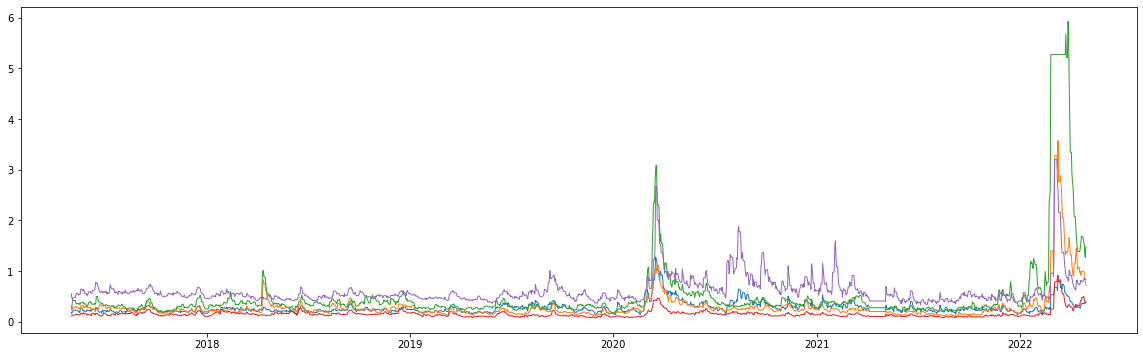

In [19]:
# Рассчитаем относительную волатильность каждого актива

# DEV
num_dev = 3000
# ema_per = 100

# ATR
num_mm      = 60    #  брать как max и min за период, например 60 мин и разницу между ними
num_atr_ema = 3000  #  и разницу между ними по EMA с каким-нибудь периодом 1000-3000

plt.rc("figure", figsize=(20, 6)) # TST

# Инициализация
vola = quotes[0][['timestamp']]
vola_D = vola.resample('1D',on='timestamp').last()
vola_D = vola_D.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
vola_D = vola_D.fillna(0) # А все что сначала не заполнилось заливаем нулями
# грохнули не нужные столбцы
vola_D.drop(['timestamp'], axis=1, inplace=True)
vola_D.reset_index(inplace=True) #Сброс индексов и timestamp уже не будет индексом 

vola_D['v_summ'] = 0 # Создадим столбец чтобы потом не орало, если он не сформируется.
vola_D['v_mean'] = 0 # Создадим столбец чтобы потом не орало, если он не сформируется.
vola_D['inv_v_summ'] = 0
vola_D['inv_v_mean'] = 0

quotes_v = quotes.copy()  # Иначе списко не копируется ! )))  Засейвим в отдельный

for i in range(0,len(quotes)):
    # DEV   думаю хреновая идея тут делать через отклонение при тренде слишком растет отклонение и снижается доля актива 
    #       что и не отражает реальность. Лучше заменить на  ATR.
#     quotes_v[i]['dev']       = quotes_v[i]['close'].rolling(num_dev).std()
#     quotes_v[i]['dev']       = quotes_v[i]['dev'].fillna(quotes_v[i].iloc[num_dev-1].dev)
#     quotes_v[i]['volat']     = 100*quotes_v[i]['dev']/quotes_v[i]['close'] 
    
    # ATR  наверное брать как max и min за период, например 60 мин и разницу между ними по EMA с каким-нибудь периодом 1000-3000 
    quotes_v[i]['max']       = quotes_v[i]['close'].rolling(num_mm).max()
    quotes_v[i]['min']       = quotes_v[i]['close'].rolling(num_mm).min()
    quotes_v[i]['atr']       = (quotes_v[i]['max'] - quotes_v[i]['min']).ewm(span=num_atr_ema, adjust=False).mean()     
    quotes_v[i]['volat']     = 100*quotes_v[i]['atr']/quotes_v[i]['close'] 
    
    # Слишком сильно колбасит, надо бы по ЕМА проехать  ХУЙНЯ ЭТО ! надо приращения домножать а не сумму их !!! тогда не будет колбасить
#     quotes_v[i]['volat']     = quotes_v[i]['volat'].ewm(span=ema_per, adjust=False).mean()   
    quotes_v[i]['inv_volat'] = 1/quotes_v[i]['volat']
    # Ресемплим на дневки перед суммированием
    # quotes_v[i] = quotes_v[i].resample('1D',on='timestamp').last()
    quotes_v[i] = quotes_v[i].resample('1D',on='timestamp').first() # Чтобы как-то приблизить к реализму потом, типа прогноз
    quotes_v[i] = quotes_v[i].fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
    quotes_v[i] = quotes_v[i].fillna(0) # А все что сначала не заполнилось заливаем нулями
    # грохнули не нужные столбцы
    quotes_v[i].drop(['timestamp'], axis=1, inplace=True)
    quotes_v[i].reset_index(inplace=True) #Сброс индексов и timestamp уже не будет индексом 
    
    vola_D['v_summ'] += quotes_v[i]['volat']  
    vola_D['inv_v_summ'] += quotes_v[i]['inv_volat']
    plt.plot(quotes_v[i].timestamp, quotes_v[i]['volat'], linewidth=1) # TST

vola_D = vola_D.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
vola_D = vola_D.fillna(0) # А все что сначала не заполнилось заливаем нулями
vola_D['v_mean'] = vola_D['v_summ']/len(quotes)
vola_D['inv_v_mean'] = vola_D['inv_v_summ']/len(quotes)
# vola_D['inv_v_mean'] = 1/vola_D['v_mean']

for i in range(0,len(quotes_v)):
    quotes_v[i]['mul'] = quotes_v[i]['inv_volat']/(vola_D['inv_v_mean'])
    quotes_v[i]['mul'] = quotes_v[i]['mul'].fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
    quotes_v[i]['mul'] = quotes_v[i]['mul'].fillna(0) # А все что сначала не заполнилось заливаем нулями

    
#---------------------------------------------------AHTUNG !!! -----------------------------------------
#     quotes_v[i]['mul'] = 1  # Отладка
#---------------------------------------------------AHTUNG !!! -----------------------------------------
#     plt.plot(quotes_v[i].timestamp, quotes_v[i]['mul'], linewidth=1) # TST

# plt.plot(quotes_v[i].timestamp, quotes_v[0]['mul']+quotes_v[1]['mul']+quotes_v[2]['mul'], linewidth=4) # TST
plt.show()    

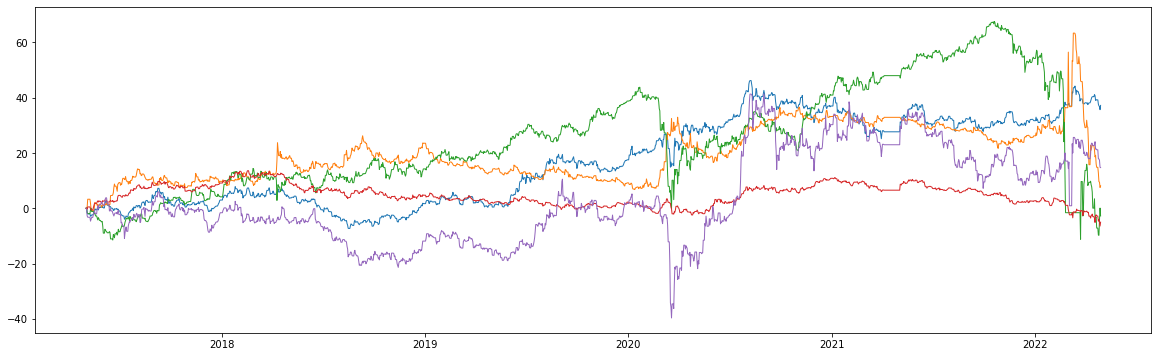

In [20]:
plt.rc("figure", figsize=(20, 6)) # TST

for i in range(0,len(quotes_v)):
    # Отладка смотрим рост %
    quotes_v[i]['sum_slice'] = (quotes_v[i]['close'] - quotes_v[i]['close'].shift(1)).fillna(0)
    quotes_v[i]['percent']   = 100*quotes_v[i]['sum_slice']/quotes_v[i]['close']
    quotes_v[i]['per_sum']   = quotes_v[i]['percent'].cumsum()
    plt.plot(quotes_v[i].timestamp, quotes_v[i]['per_sum'], linewidth=1) # TST
    
plt.show()    

In [21]:

quotes_v[0]

,timestamp,open,high,low,close,vol,max,min,atr,volat,inv_volat,mul,sum_slice,percent,per_sum
0,2017-05-02,1270.8,1270.8,1258.1,1259.2,3250.0,1260.1,1257.8,2.300000,0.182772,5.471304,1.189237,0.0,0.000000,0.000000
1,2017-05-03,1258.8,1258.8,1257.3,1257.8,108.0,1259.7,1257.8,2.087450,0.165960,6.025533,1.269737,-1.4,-0.111305,-0.111305
2,2017-05-04,1240.0,1240.0,1237.0,1238.4,1361.0,1245.6,1238.4,2.551484,0.206031,4.853645,1.114833,-19.4,-1.566537,-1.677843
3,2017-05-05,1231.6,1234.2,1231.6,1233.6,326.0,1233.6,1229.8,2.858548,0.231724,4.315477,1.086664,-4.8,-0.389105,-2.066948
4,2017-05-06,1231.6,1234.2,1231.6,1233.6,326.0,1233.6,1229.8,2.858548,0.231724,4.315477,1.086664,0.0,0.000000,-2.066948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,2022-04-25,1933.0,1933.0,1920.0,1924.5,1217.0,1945.6,1924.5,6.982927,0.362844,2.756007,1.820571,-30.0,-1.558846,37.641756
1820,2022-04-26,1911.1,1917.4,1910.5,1912.8,525.0,1912.8,1906.8,7.214479,0.377169,2.651335,1.720665,-11.7,-0.611669,37.030087
1821,2022-04-27,1910.5,1910.7,1906.1,1908.0,347.0,1913.7,1908.0,6.753440,0.353954,2.825227,1.699291,-4.8,-0.251572,36.778514
1822,2022-04-28,1892.0,1895.7,1885.0,1886.7,906.0,1897.9,1886.7,7.128918,0.377851,2.646545,1.567734,-21.3,-1.128955,35.649559


In [22]:
# Нужно придумать как хранить данные по параметрам всех стратегий ! и потом исходя из него формировать столбец strategy.csv
# Скорее всего в strategy.csv нужно будет тоже добавить столбец [str_mod] , чтобы по этим ключам связываться с таблицей strategy_params
# Например в такой таблице "strategy_params":
# [strategy] [str_mod] []... параметры типа Shift_Filtr, EMA1_Trend, и т.д. ... []
#    для каждой str_mod соответсвует свой набор параметров
#    Каждая strategy соответсвует функции стратегий в my_module

# 1. Считаем стратегии из файла strategy.csv и  strategy_params.csv 
#    или лучше создадим список стратегий с необходимыми параметрами на основе этих файлов. 
#    Например к strategy_params.csv добавляются параметры типа time_shift и candle_per
#    Пока сделаем тут, потом если что перенесем в strategy_params.csv и далее strategy.csv 


round_price = 0

# Занесем список имен стратегий
strategies = pd.Series(['elder_macd', 'kama_er_lvl','kama_sm_tst','e_kama_sm','kama_trend','kama_tr_macd_osc','e_kama_sm2',
                        'e_kama_sm4','e_kama_sm6','osc_macd','osc_macd1','osc_tr_multy'])

# Заносим данные в таблицу  strategy_params    
# Считываем из файла таблицу, если его нет, то создаем её
if os.path.exists('strategies_analyse.csv'):
    strategies_analyse = pd.read_csv('strategies_analyse.csv', sep=';')  # , index_col=0
else:
#     strategies_analyse = pd.DataFrame(columns=['strategy','str_mod','time_shift','candle_per', 'Shift_Filtr', 'KAMA_PER', 'TR_LVL', 'EMA1_Trend', 'EMA2_Trend', 'EMA_MACD_Trend', 'EMA1_Osc', 'EMA2_Osc', 'EMA_MACD_Osc', 'T_ENT', 'T_EXT', 'F_ENT', 'F_EXT', 'm_ema_per', 'm_donch_per', 'm_k_dohch'])
    strategies_analyse = pd.DataFrame(columns=['strategy','p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14','p15','p16','p17','p18','p19','p20'])
#     strategies_analyse.loc[0] = [strategies[0], 0, 10, 60, 0,  0,   0, 20, 30, 3, 1, 3, 5, 1.3, 0.5, 100, 0.5, 3, 30, 0.1] # elder_macd_profit - 0
    strategies_analyse.loc[0] = [strategies[3], 'time_shift=10','candle_per=60', 'Shift_Filtr=0', 'KAMA_PER=10', 'TR_LVL=0.7','EMA1_Osc=1', 'EMA2_Osc=3','EMA_MACD_Osc=5', 'T_ENT=1.6', 'T_EXT=0.6', 'F_ENT=100.0', 'F_EXT=0.6', 'm_ema_per=6', 'm_donch_per=3', 'm_k_dohch=0.2',16,17,18,19,20] # 
    strategies_analyse.loc[1] = [strategies[3], 'time_shift=10','candle_per=50', 'Shift_Filtr=0', 'KAMA_PER=10', 'TR_LVL=0.6','EMA1_Osc=1', 'EMA2_Osc=3','EMA_MACD_Osc=5', 'T_ENT=1.7', 'T_EXT=0.6', 'F_ENT=100.0', 'F_EXT=0.6', 'm_ema_per=6', 'm_donch_per=3', 'm_k_dohch=0.2',16,17,18,19,20] # 
    strategies_analyse.loc[2] = [strategies[3], 'time_shift=10','candle_per=40', 'Shift_Filtr=0', 'KAMA_PER=10', 'TR_LVL=0.5','EMA1_Osc=1', 'EMA2_Osc=3','EMA_MACD_Osc=5', 'T_ENT=1.8', 'T_EXT=0.6', 'F_ENT=100.0', 'F_EXT=0.6', 'm_ema_per=6', 'm_donch_per=3', 'm_k_dohch=0.2',16,17,18,19,20] # 

strategies_analyse.to_csv('strategies_analyse.csv', sep=';', index=False)


strategies_analyse

,strategy,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20
0,osc_tr_multy,direction=0,stop_hour=180,filtration=3,shift_filtr=0,enter_exit=2,TR_LVL=0.25,KAMA_PER=6,candle_per=60,donch_per=10,...,f_macd2=20,K_ENT=0.60,K_EXT=0.80,ema_micro=60,EMA2_Osc=3,EMA_MACD_Osc=5,m_donch_per=3,m_k_dohch=0.2,NaN,NaN
1,osc_tr_multy,direction=0,stop_hour=180,filtration=3,shift_filtr=0,enter_exit=0,TR_LVL=0.3,KAMA_PER=6,candle_per=50,donch_per=10,...,f_macd2=20,K_ENT=0.5,K_EXT=0.7,ema_micro=5,EMA2_Osc=3,EMA_MACD_Osc=5,m_donch_per=3,m_k_dohch=0.2,NaN,NaN


  0%|          | 0/2 [00:00<?, ?it/s]

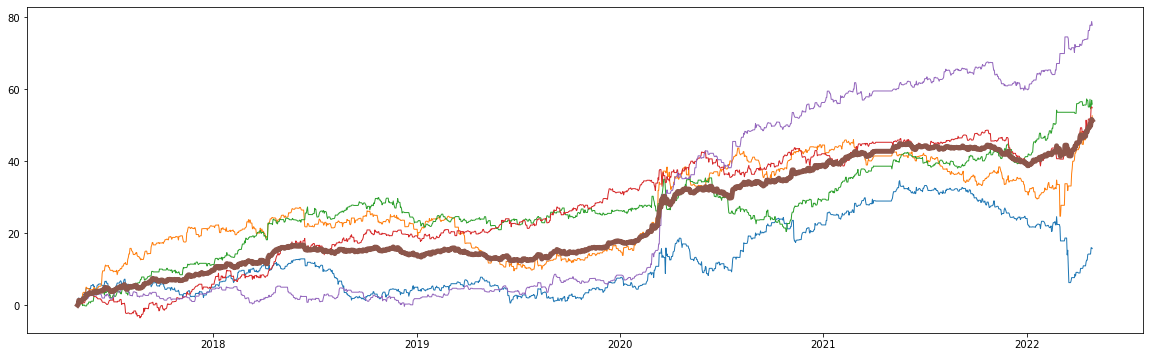

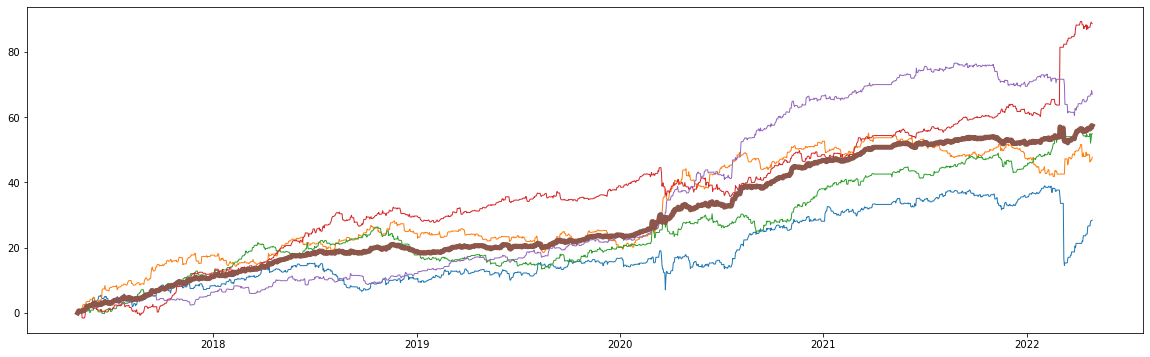

Время цикла= 6.691008806228638 секунд или  0  минут


In [23]:
ftime = time.time() #Засекаем время

# Подготовим таймфрейм для записи в него данных с временным сдвигом и потом усредним
df = quotes[0].copy(deep=False)
df.index = df['timestamp']
# df.drop(['timestamp','open','high','low','close','vol'], axis=1, inplace=True)
df.drop(df.columns, axis=1, inplace=True)
df.reset_index(inplace=True) #Сброс индексов и timestamp уже не будет индексом

# Ресемплим всё на дневки
df = df.resample('1D',on='timestamp').last() # по средней-то сглаживаются провалы и слишком идеально как-то все
df = df.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
df = df.fillna(0) # А все что сначала не заполнилось заливаем нулями
# грохнули не нужные столбцы
df.drop(['timestamp'], axis=1, inplace=True)
df.reset_index(inplace=True) #Сброс индексов и timestamp уже не будет индексом 

df_m = df.copy(deep=False)

PROFIT_PERC  = df.copy(deep=False)
PROFIT_PERC_m = df.copy(deep=False)

i_prev = 0

# 2. Прогоняем стратегии по минуткам с микровходом. И заносим следующие значения в 4(2) разные таблицы добавляюю merge по столбцу timestamp
#     - "PROFIT_PIP_m"
#     - "PROFIT_PERC_m"
#     - "PROFIT_PIP"
#     - "PROFIT_PERC"

# Инициализация датафреймов

for i in tqdm_notebook(range(len(strategies_analyse))):
    # 2.1 Загрузим текущий набор параметров для данной стратегии из strategies_analyse V4   
    p = pd.Series()
    for k in range(len(strategies_analyse.loc[i])):
        if '=' in str(strategies_analyse.loc[i][k]):
            p[strategies_analyse.loc[i][k].split('=')[0]] = strategies_analyse.loc[i][k].split('=')[1]   
    curr_strategy = strategies_analyse.loc[i][0]
    # V4 End
    m_round_price = 0      # Потом допилить нормально
      
    #     Инициализация перед for
    df = df[['timestamp']] # С каждым новым значением i в df должен убрать все заброшенные внего столбцы кроме 'timestamp'
    df_m = df_m[['timestamp']] # С каждым новым значением i в df должен убрать все заброшенные внего столбцы кроме 'timestamp'
    df['SUMM_PERC'] = 0 # Создадим столбец чтобы потом не орало, если он не сформируется.
    df_m['SUMM_PERC'] = 0 # Создадим столбец чтобы потом не орало, если он не сформируется.
    
       
    # Инициализация
    num = 0
    # V5 надо накуй всё трасформить в дневки и потом их складывать и т.д. иначе че там по merge будет хз
    df_all_midd = quotes[0][['timestamp']]
    # Ресемплим в дневки
    df_all_midd = df_all_midd.resample('1D',on='timestamp').last() # по средней-то сглаживаются провалы и слишком идеально как-то все
    df_all_midd = df_all_midd.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
    df_all_midd = df_all_midd.fillna(0) # А все что сначала не заполнилось заливаем нулями
    # грохнули не нужные столбцы
    df_all_midd.drop(['timestamp'], axis=1, inplace=True)
    df_all_midd.reset_index(inplace=True) #Сброс индексов и timestamp уже не будет индексом 
        
    df_all_midd['SUMM_PERC'] = 0 # Создадим столбец чтобы потом не орало, если он не сформируется.

    num_pic_strat = i # номер стратегии отображаемой на графике, показывают доходности по всем активам
    if i == num_pic_strat :
        plt.rc("figure", figsize=(20, 6)) # TST

    # Мультикотировка
    for j in range(0,len(quotes)):

        if curr_strategy == strategies.values[3]: # 'e_kama_sm'                
#                 tst, data = elder_ema_kama_profit_SM_TST(quotes[j], time_shift, candle_per, Shift_Filtr, KAMA_PER, TR_LVL, EMA1_Osc, EMA2_Osc, EMA_MACD_Osc, T_ENT, T_EXT, F_ENT, F_EXT)            
            tst, data = elder_ema_kama_profit_SM_TST(quotes[j], int(p.time_shift), int(p.candle_per), int(p.Shift_Filtr), int(p.KAMA_PER), float(p.TR_LVL), int(p.EMA1_Osc), int(p.EMA2_Osc), int(p.EMA_MACD_Osc), float(p.T_ENT), float(p.T_EXT), float(p.F_ENT), float(p.F_EXT)) # v4

        elif curr_strategy == strategies.values[4]: # 'kama_trend'
            
            tst, data = kama_trend(quotes[j], int(p.d_shift), int(p.d_candle_per), int(p.d_kama_per),int(p.d_kama_min), int(p.d_kama_max), int(p.d_atr_per), float(p.d_k_atr))
            
        elif curr_strategy == strategies.values[5]: # 'kama_tr_macd_osc'
#             data, tst = kama_tr_macd_osc(quotes[j], shift, int(tbl.candle_per[i]), int(tbl.kama_per[i]),kama_min, kama_max,           atr_per,           tbl.k_atr[i],EMA1_Osc, EMA2_Osc, EMA_MACD_Osc, tbl.ENT[i])
            tst, data = kama_tr_macd_osc(quotes[j], int(p['shift']), int(p.candle_per), int(p.kama_per),int(p.kama_min), int(p.kama_max), int(p.atr_per), float(p.k_atr), int(p.EMA1_Osc), int(p.EMA2_Osc), int(p.EMA_MACD_Osc), float(p.ENT))
#             tst, data = kama_tr_macd_osc(quotes[j], 10, 40, 10,2, 30, 50, 0.07, 1, 3, 5, 1.10)
 
        elif curr_strategy == strategies.values[6]: # 'e_kama_sm2'                
            tst, data = e_kama_sm2(quotes[j], int(p.time_shift), int(p.candle_per), int(p.Shift_Filtr), int(p.KAMA_PER), float(p.TR_LVL), int(p.EMA1_Osc), int(p.EMA2_Osc), int(p.EMA_MACD_Osc), float(p.T_ENT), float(p.T_EXT), float(p.F_ENT), float(p.F_EXT)) # v4    
            
        elif curr_strategy == strategies.values[7]: # 'e_kama_sm4'                
            tst, data = e_kama_sm4(quotes[j], int(p.time_shift), int(p.candle_per), int(p.Shift_Filtr), int(p.KAMA_PER), float(p.TR_LVL), float(p.TR_STOP), int(p.EMA1_Osc), int(p.EMA2_Osc), int(p.EMA_MACD_Osc), float(p.T_ENT), float(p.T_EXT), float(p.F_ENT), float(p.F_EXT))     
            
        elif curr_strategy == strategies.values[8]: # 'e_kama_sm6'    
            #data, tst = e_kama_sm6(curr_m, candle_per, Shift_Filtr, KAMA_PER, TR_LVL,TR_STOP, EMA2_Osc, EMA_MACD_Osc, T_ENT, T_EXT, F_ENT, F_EXT,ema_micro)
            tst, data = e_kama_sm6(quotes[j], int(p.candle_per), int(p.Shift_Filtr), int(p.KAMA_PER), float(p.TR_LVL), float(p.TR_STOP),  int(p.EMA2_Osc), int(p.EMA_MACD_Osc), float(p.T_ENT), float(p.T_EXT), float(p.F_ENT), float(p.F_EXT),int(p.ema_micro))                                        
            
        elif curr_strategy == strategies.values[9]: # 'osc_macd'    
            #data, tst = osc_macd(quotes[j], int(tbl.direction[i]), int(tbl.candle_per[i]), EMA2_Osc, EMA_MACD_Osc, tbl.K_ENT[i], tbl.K_EXT[i], ema_micro) #                
            tst, data = osc_macd(quotes[j], int(p.direction), int(p.candle_per), int(p.EMA2_Osc), int(p.EMA_MACD_Osc), float(p.K_ENT), float(p.K_EXT),int(p.ema_micro)) #                
            
        elif curr_strategy == strategies.values[10]: # 'osc_macd1' 
            #data, tst = osc_macd1(quotes[j], int(tbl.direction[i]), int(tbl.candle_per[i]), int(tbl.f_macd1[i]), int(tbl.f_macd2[i]), EMA2_Osc, EMA_MACD_Osc, tbl.K_ENT[i], tbl.K_EXT[i], ema_micro) #                            
            tst, data = osc_macd1(quotes[j], int(p.direction), int(p.candle_per),int(p.f_macd1),int(p.f_macd2), int(p.EMA2_Osc), int(p.EMA_MACD_Osc), float(p.K_ENT), float(p.K_EXT),int(p.ema_micro)) #                
            
        if curr_strategy == strategies.values[11]: # 'osc_tr_multy'             
            #data, tst = osc_tr_multy(quotes[j], int(tbl.direction[i]), int(tbl.stop_hour[i]), int(tbl.filtration[i]), int(tbl.enter_exit[i]), int(tbl.candle_per[i]), int(tbl.donch_per[i]), int(tbl.f_macd1[i]), int(tbl.f_macd2[i]), EMA2_Osc, EMA_MACD_Osc, tbl.K_ENT[i], tbl.K_EXT[i], ema_micro) #            
            #data, tst = osc_tr_multy(quotes[j], int(tbl.direction[i]), int(tbl.stop_hour[i]), int(tbl.filtration[i]), int(tbl.shift_filtr[i]), int(tbl.enter_exit[i]), tbl.TR_LVL[i], int(tbl.KAMA_PER[i]), int(tbl.candle_per[i]), int(tbl.donch_per[i]), int(tbl.f_macd1[i]), int(tbl.f_macd2[i]), EMA2_Osc, EMA_MACD_Osc, tbl.K_ENT[i], tbl.K_EXT[i], int(tbl.ema_micro[i])) #
            tst, data = osc_tr_multy(quotes[j],   int(p.direction),       int(p.stop_hour),      int(p.filtration),       int(p.shift_filtr),   int(p.enter_exit),   float(p.TR_LVL), int(p.KAMA_PER),  int(p.candle_per),         int(p.donch_per),     int(p.f_macd1),int(p.f_macd2), int(p.EMA2_Osc), int(p.EMA_MACD_Osc), float(p.K_ENT), float(p.K_EXT), int(p.ema_micro)) 
            
              
                                    
            
            
            

#             data_m = micro_enter_v4(data,quotes[j],m_ema_per,m_donch_per,m_k_dohch,m_round_price)    # Пока без микро
           
        df1 = data[['timestamp','SUMM_PERC']]          
        
#             df1 = data_m[['timestamp','SUMM_PERC_m']]                                             # Пока без микро

        # V5 надо накуй всё трасформить в дневки и потом их складывать и т.д. иначе че там по merge будет хз
        df1 = df1.resample('1D',on='timestamp').last() # по средней-то сглаживаются провалы и слишком идеально как-то все
        df1 = df1.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
        df1 = df1.fillna(0) # А все что сначала не заполнилось заливаем нулями
        # грохнули не нужные столбцы
        df1.drop(['timestamp'], axis=1, inplace=True)
        df1.reset_index(inplace=True) #Сброс индексов и timestamp уже не будет индексом        

        # V5 Вначале нарежем на приращения ежедневные df1[SUMM_PERC] а потом домножим  на множитель относительной волатильности # quotes_v[j]['mul']
        df1['sum_slice'] = (df1['SUMM_PERC'] - df1['SUMM_PERC'].shift(1)).fillna(0)        
        df1['sum_mul'] = (df1['sum_slice']*quotes_v[j]['mul']).cumsum() 
        df1['SUMM_PERC'] = df1['sum_mul']
        df1 = df1.loc[:, df1.columns.intersection(['timestamp','SUMM_PERC'])]  # Оставляем только один 'timestamp','SUMM_PERC'
   
        # reInit df2
        df2 = quotes[0][['timestamp']]  # ВНИМАНИЕ !!! ТУТ НАДО НАРОСТИТЬ df2 до stop_date/ start_date !!!! Наростили
        # Ресемплим в дневки
        df2 = df2.resample('1D',on='timestamp').last() # по средней-то сглаживаются провалы и слишком идеально как-то все
        df2 = df2.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
        df2 = df2.fillna(0) # А все что сначала не заполнилось заливаем нулями
        # грохнули не нужные столбцы
        df2.drop(['timestamp'], axis=1, inplace=True)
        df2.reset_index(inplace=True) #Сброс индексов и timestamp уже не будет индексом 
        
        df2 = pd.merge(df2,df1, how='outer', on='timestamp') # А как насчет того чтобы тупо по merge сливаться с эталоном и тогда  'timestamp' будет всегда четкий
        df2 = df2.fillna(method='ffill')               # Заполняем дыры предыдущим действительным значением
        df2 = df2.fillna(0) 
        #print(df2)

        if i == num_pic_strat :
            df2_D = df2.resample('1D',on='timestamp').last()
            df2_D = df2_D.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
            df2_D = df2_D.fillna(0) # А все что сначала не заполнилось заливаем нулями
            
            plt.plot(df2_D.index, df2_D.SUMM_PERC, linewidth=1) # TST

        # Вычисляем сумму всего профита для вычисления среднее значение профита  потом
        # Ваще-то лучшебы уже тут ресемпленные данные дневки использовать.
        df_all_midd = pd.concat([df_all_midd, df2], axis=0).groupby('timestamp').sum().reset_index()


        # Вычисляем количество сделок 
        num += round(len(data)/2) 


    num = round(num/len(quotes))                                # Среднее количество сделок
    df_all_midd.SUMM_PERC = df_all_midd.SUMM_PERC/len(quotes)   # Среднее значение процента профита            

    df = df_all_midd

#       df   = pd.merge(df,df_all_midd, how='left', on='timestamp') # Тут ваще походу не надо это, т..к
#       df_m = pd.merge(df_m,df_all_midd, how='left', on='timestamp')                                   # Пока без микро
    df.rename(  columns={ 'SUMM_PERC'   : 'SUMM_MIDD' },   inplace=True)
#       df_m.rename(columns={ 'SUMM_PERC_m' : 'SUMM_MIDD_m' }, inplace=True)                  # Пока без микро  

    #   Перед тем как очистить df нужно из его предыдущего расчета среднюю закинуть в PROFIT_PERC, и назвать столбец соотв
    PROFIT_PERC   = pd.merge(PROFIT_PERC  ,df  , how='left', on='timestamp')
    PROFIT_PERC_m = pd.merge(PROFIT_PERC_m,df_m, how='left', on='timestamp')

    if i == num_pic_strat :
        midd_D = PROFIT_PERC.resample('1D',on='timestamp').last()
        midd_D = midd_D.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
        midd_D = midd_D.fillna(0) # А все что сначала не заполнилось заливаем нулями
        plt.plot(midd_D.index, midd_D.SUMM_MIDD, linewidth=5) # TST
        plt.show()
        
    #   Заносим имя столбца с соответствующим номером стратегии, просто номер нафиг слово ещё
    PROFIT_PERC.rename(  columns={'SUMM_MIDD'  : 's'+str(i)}, inplace=True) 
    PROFIT_PERC_m.rename(columns={'SUMM_MIDD_m': 's'+str(i)}, inplace=True) 
#     PROFIT_PERC.rename(columns={'SUMM_MIDD': 'strategy='+str(i)}, inplace=True) 
#     if (i != 0): 
#         print(i,' Percent = ',round(100*i/len(strategies_analyse),2),' до конца осталось ',((1/(i/len(strategies_analyse)) - 1 )*(time.time() - ftime))/60,' минут')
    
PROFIT_PERC   = PROFIT_PERC.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
PROFIT_PERC   = PROFIT_PERC.fillna(0) # А все что сначала не заполнилось заливаем нулями 
PROFIT_PERC_m = PROFIT_PERC_m.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
PROFIT_PERC_m = PROFIT_PERC_m.fillna(0) # А все что сначала не заполнилось заливаем нулями 

endtime = time.time() - ftime
print("Время цикла=",endtime,"секунд или ", int(endtime/60),' минут')

In [24]:
#  НЕ ИСПОЛЬЗОВАТЬ ПРИ ПЕРВОМ ПРОХОДЕ !!!!!! ЧТЕНИЕ ПРОЦЕНТОВ
# PROFIT_PERC  = pd.read_csv('PROFIT_PERC.csv', sep=';')
# PROFIT_PERC_m  = pd.read_csv('PROFIT_PERC_m.csv', sep=';')
# df2
# df_all_midd
# tst
# data
# data.to_csv('data.csv', sep=';',index=False)

In [25]:
# НАХУЙ БЛЯТЬ ПО МИНУТКАМ ЭТИ ДАННЫЕ ИСПОЛЬЗОВАТЬ ?! СВЕРНУТЬ ПО ДНЕВКАМ МИНИМУМ А ТО И ПО НЕДЕЛЬКАМ ! КАК в BackTest !
# PROFIT_PERC = PROFIT_PERC.resample('1D',on='timestamp').mean()

PROFIT_PERC = PROFIT_PERC.resample('1D',on='timestamp').last() # блять по средней-то сглаживаются провалы и слишком идеально как-то все
# PROFIT_PERC = PROFIT_PERC.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
# PROFIT_PERC = PROFIT_PERC.fillna(0) # А все что сначала не заполнилось заливаем нулями
# грохнули не нужные столбцы
PROFIT_PERC.drop(['timestamp'], axis=1, inplace=True)
PROFIT_PERC.reset_index(inplace=True) #Сброс индексов и timestamp уже не будет индексом 



# PROFIT_PERC = PROFIT_PERC.resample('1W',on='timestamp').mean()

# PROFIT_PERC.reset_index(inplace=True) #Сброс индексов и timestamp уже не будет индексом  
# PROFIT_PERC = PROFIT_PERC.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
# PROFIT_PERC = PROFIT_PERC.fillna(0) # А все что сначала не заполнилось заливаем нулями


#  ПОКА БЕЗ МИКРО !!!
# PROFIT_PERC_m = PROFIT_PERC_m.resample('1D',on='timestamp').mean()
# PROFIT_PERC_m.reset_index(inplace=True) #Сброс индексов и timestamp уже не будет индексом  
# PROFIT_PERC_m = PROFIT_PERC_m.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
# PROFIT_PERC_m = PROFIT_PERC_m.fillna(0) # А все что сначала не заполнилось заливаем нулями


PROFIT_PERC.tail(5)

,timestamp,s0,s1
1819,2022-04-25,50.289710,56.376542
1820,2022-04-26,49.809572,56.495923
1821,2022-04-27,50.953369,56.910116
1822,2022-04-28,51.589304,57.410845
1823,2022-04-29,51.348185,57.326970


In [26]:
# Сохранить котировки !
PROFIT_PERC.to_csv('PROFIT_PERC.csv', sep=';',index=False)
# PROFIT_PERC_m.to_csv('PROFIT_PERC_m.csv', sep=';',index=False)

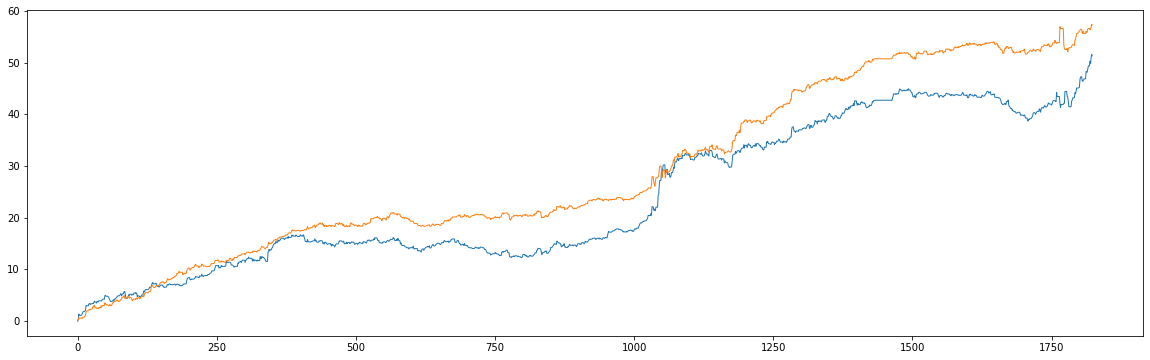

In [27]:
# Отобразим на графике доходности
plt.rc("figure", figsize=(20, 6))

for i in range(len(strategies_analyse)):
    plt.plot(PROFIT_PERC.index, PROFIT_PERC.iloc[:,i+1], linewidth=1) 

In [28]:
# ========================================================================================================================
#  БЕЗ ЗНАЧЕНИЙ МИКРОВХОДА !!! по PROFIT_PERC

# 4. NEW v6 !!! Перебеираются все наборы и комбинации из n-стратегий со всеми параметрами. 
#    т.е. обычно не более 3-х(4-х) стратегий в комбинации, обычно так и получается.
#    в этом и есть отличие от предыдущего варианта ! А значит более быстрые вычисления и больше стратегий можно перебрать

ftime = time.time() #Засекаем время
num_strategies = len(strategies_analyse)
tbl_s = pd.DataFrame(columns=['comb','prof_dd','max_prof','max_dd'])


num_max_str_cmb = 4   # Максимально количество стратегий рассматриваемое как рабочая комбинация. 61 по 3 делается 10 минут

num_combinations = len(list(combinations(range(0, num_strategies), num_max_str_cmb))) # len(list(combinations(range(1, n), k)))

# Отлажено ! Цикл работает, заносит в list_comb списко всех комбинаций стратегий до num_max_str_cmb включительно
list_comb = []   # Init list
# Цикл перебора до максимального количества стратегий в сете от 1
for curr_list_num_str in range(1,num_max_str_cmb+1):
    # Цикл перебора элементов добавляемого списка к текущему списку    
    for curr_new_list_item in range(len(list(combinations(range(0, num_strategies), curr_list_num_str)))):
        list_comb.append(list(combinations(range(0, num_strategies), curr_list_num_str))[curr_new_list_item])
        
# Перебор всех комбинаций стратегий
for curr_combination in tqdm_notebook(range(len(list_comb))):  
 
    # Расчитаем средний профит текущей комбинации стратегий PROFIT_PERC
    
    # С каждым новым циклом перебора list_comb в df должен убрать все заброшенные внего столбцы кроме 'timestamp'
    # Подготовим таймфрейм для записи в него данных с временным сдвигом и потом усредним
    df = PROFIT_PERC.copy(deep=False)
    df = df[['timestamp']] 
    
    # Перебор всех стратегий в данной итерации и расчет их среднего значения
    for curr_strategy in range(0,len(list_comb[curr_combination])):
        # Закинем в df только те номера столбцов из PROFIT_PERC, у которых текущее значение в list_comb[curr_combination]
        df = pd.concat([df, PROFIT_PERC.iloc[:,[0,list_comb[curr_combination][curr_strategy]+1]]], axis=0).groupby('timestamp').sum().reset_index() #NEW2
        
    # Теперь посчитаем среднее всех стратегий    
    df = df.iloc[:, [0]].join(df.iloc[:, 1:].mean(axis=1).rename('SUMM_MIDD'))

    #     В df посчитали среднюю прибыль текущей комбинации расчетов, далее из этого весь остальной анализ!
    maximum = np.maximum.accumulate(df.iloc[:,1])
    draw_down = maximum - df.SUMM_MIDD # Текущая просадка
    max_draw_down = draw_down.max() # Рассчитали максимальную просадку это просто одно число !
    max_profit = maximum.max() #Рассчитали максимальный профит
    prof_dd = max_profit/max_draw_down
    
    tbl_s.loc[curr_combination,'comb'] = list_comb[curr_combination]
    # Теперь занесем в нашу итоговую таблицу tbl_s, в соответсвующую строку соответсвующий параметр
    tbl_s.loc[curr_combination,'prof_dd'] = prof_dd
    tbl_s.loc[curr_combination,'max_prof'] = max_profit
    tbl_s.loc[curr_combination,'max_dd'] = max_draw_down

#     ЗАБЫЛ ДОБАВИТЬ ПАРАМЕТР КОЛИЧЕСТВО СДЕЛОК !!! ПОТОМ ДОБАВИТЬ !!!
#     ЗАБЫЛ ДОБАВИТЬ ПАРАМЕТР СРЕДНЕМЕСЯЧНЫЙ ПАРАМТЕР  prof/dd	max_prof	max_dd

# в числа переведем необходимые столбцы
tbl_s[['prof_dd','max_prof','max_dd']] = tbl_s[['prof_dd','max_prof','max_dd']].apply(pd.to_numeric) 

endtime = time.time() - ftime
print("Время цикла=",endtime,"секунд или ", int(endtime/60),' минут')

list_comb

tbl_s

# ВРОДЕ НОРМ ! ПРОВЕРИТЬ РАСЧЕТЫ ВРУЧНУЮ В ЭКСЕЛЕ ! ПРОВЕРИЛ ВСЁ ПРАВИЛЬНО !

  0%|          | 0/3 [00:00<?, ?it/s]

Время цикла= 0.028469085693359375 секунд или  0  минут


,comb,prof_dd,max_prof,max_dd
0,"(0,)",8.277030,51.589304,6.232828
1,"(1,)",11.761523,57.410845,4.881243
2,"(0, 1)",14.325686,54.500074,3.804361


In [29]:
#  НЕ ИСПОЛЬЗОВАТЬ ПРИ ПЕРВОМ ПРОХОДЕ !!!!!!
# tbl_s    = pd.read_csv('tbl_s.csv', sep=';')
# tbl_s_m  = pd.read_csv('tbl_s_m.csv', sep=';')

In [30]:
tbl_s.to_csv('tbl_s_no_sort.csv', sep=';', index=False)
tbl_s.sort_values(by = ['prof_dd'],ascending=False, inplace=True)
tbl_s.to_csv('tbl_s.csv', sep=';', index=False)
tbl_s.head(15)

,comb,prof_dd,max_prof,max_dd
2,"(0, 1)",14.325686,54.500074,3.804361
1,"(1,)",11.761523,57.410845,4.881243
0,"(0,)",8.277030,51.589304,6.232828


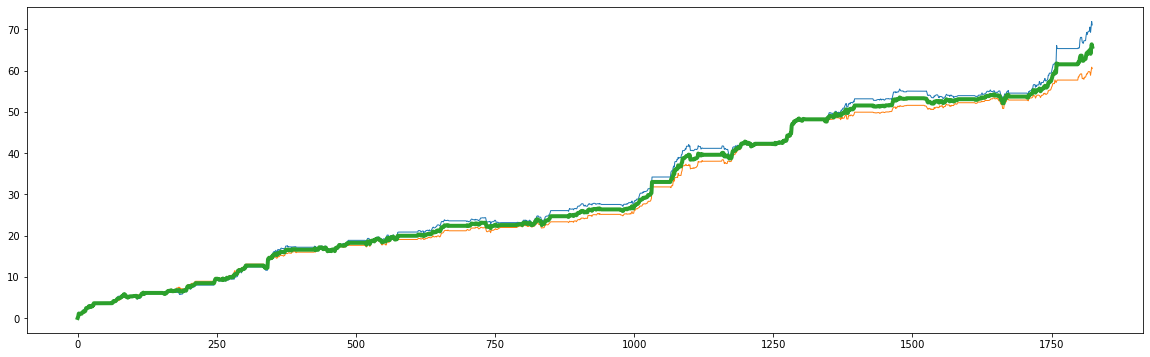

In [18]:
# Отобразим на графике доходности самый топчик
df2 = PROFIT_PERC.copy(deep=False)
df2 = df2[['timestamp']] 

# Перебор всех стратегий в топовой итерации и расчет их среднего значения
for curr_strategy in range(0,len(tbl_s.comb[tbl_s.loc[:,'prof_dd'].idxmax()])):
    # Закинем в df только те номера столбцов из PROFIT_PERC, у которых текущее значение в list_comb[curr_combination]
    df2 = pd.concat([df2, PROFIT_PERC.iloc[:,[0,list_comb[curr_combination][curr_strategy]+1]]], axis=0).groupby('timestamp').sum().reset_index() #NEW2
    plt.plot(PROFIT_PERC.index, PROFIT_PERC.iloc[:,curr_strategy+1], linewidth=1)
# Теперь посчитаем среднее всех стратегий и нарисуем жирно   
df2 = df2.iloc[:, [0]].join(df2.iloc[:, 1:].mean(axis=1).rename('SUMM_MIDD'))
plt.plot(df2.index, df2.iloc[:,1], linewidth=4)

In [ ]:

#--------------------------------------- НИЖЕ ХЗ НАДО РАЗБИРАТЬСЯ ЧТО ТАМ ------------------------------------------------


In [129]:
# Нужно сделать отбор лучших стратегий и симуляцию их работы с общей загрузкой по лотам и 
#     формирование файлов 
#     strategy.csv
#     strategy_params.csv

ftime = time.time() #Засекаем время

# Подготовим таймфрейм для записи в него данных с временным сдвигом 
df = curr_m.copy(deep=False)
df.index = df['timestamp']
df.drop(['timestamp','open','high','low','close','vol'], axis=1, inplace=True)
df.reset_index(inplace=True) #Сброс индексов и timestamp уже не будет индексом

ALL_PROFIT_PERC  = df.copy(deep=False)
ALL_PROFIT_PERC_m = df.copy(deep=False)
TRADES = df.copy(deep=False)

# 1. Сформируем файл как в strategy.csv и (strategy_params.csv) для удобства симуляции

strategy = pd.DataFrame(columns=['ticker', 'strategy', 'str_mod', 'time_shift', 'candle_per','time_marker', 'curr_shift', 
                                 'prev_pos', 'curr_pos','state', 'position', 'tst_perc', 'real_perc', "check_flag", "lots"])
strategy_params = pd.DataFrame(columns=['strategy', 'str_mod', 'Shift_Filtr', 'KAMA_PER', 'TR_LVL', 'EMA1_Trend','EMA2_Trend', 'EMA_MACD_Trend',
                                        'EMA1_Osc', 'EMA2_Osc', 'EMA_MACD_Osc', 'T_ENT', 'T_EXT', 'F_ENT', 'F_EXT', 'm_ema_per', 'm_donch_per', 'm_k_dohch'])
strategy_params_num = 0

for i in range(len(strategies_analyse)):
    #     отбираем номера только тех стратегий, которые оказались
    if(int(tbl_s.comb[tbl_s.loc[:,'prof/dd'].idxmax()],2) >> i & 1 == 1):
#         print('strategy_num ',i)
#         print(strategies_analyse.iloc[i])

#         print(strategies_analyse.strategy.iloc[i])
#         strategy_params.iloc[strategy_params_num] = strategies_analyse.iloc[i]
#         strategy_params.iloc[strategy_params_num] = pd.merge(strategy_params.iloc[strategy_params_num],strategies_analyse.iloc[i])
#         strategy_params.strategy.iloc[strategy_params_num] = 
    
        strategy_params_num = strategy_params_num + 1
        
        
        
# 2. Проведем симуляцию всех стратегий с учетом смещения по времени, чтбы оценить загрузку лотами.

#  Эти закомментаренные ниже 6 строк осталось от многоходовочного варианта со сдвижками. он неэффективен, старье вощем.
#         # Запустим цикл по сдвижкам времени и с накоплением результатов по сделкам в и профитам в датафреймы.
#         for curr_timeshift in range(0,strategies_analyse.candle_per.iloc[i],strategies_analyse.time_shift.iloc[i]):
# #             print(curr_timeshift)       
#             # Выбрали часовики текущей стратегии 
#             curr_h = shift_quotes(curr_m, curr_timeshift,strategies_analyse.candle_per.iloc[i])
#             curr_strategy = 0 #strategies_analyse.strategy.iloc[i]
            
        Shift_Filtr = strategies_analyse.Shift_Filtr.iloc[i]
        KAMA_PER = strategies_analyse.KAMA_PER.values[i]
        TR_LVL = strategies_analyse.TR_LVL.values[i]        
        EMA1_Trend  = strategies_analyse.EMA1_Trend.values[i]
        EMA2_Trend  = strategies_analyse.EMA2_Trend.values[i]
        EMA_MACD_Trend  = strategies_analyse.EMA_MACD_Trend.values[i]
        EMA1_Osc  = strategies_analyse.EMA1_Osc.values[i]
        EMA2_Osc  = strategies_analyse.EMA2_Osc.values[i]
        EMA_MACD_Osc  = strategies_analyse.EMA_MACD_Osc.values[i]
        T_ENT  = strategies_analyse.T_ENT.values[i]
        T_EXT  = strategies_analyse.T_EXT.values[i]
        F_ENT  = strategies_analyse.F_ENT.values[i]
        F_EXT  = strategies_analyse.F_EXT.values[i]
        m_ema_per = strategies_analyse.m_ema_per.values[i]
        m_donch_per = strategies_analyse.m_donch_per.values[i]
        m_k_dohch = strategies_analyse.m_k_dohch.values[i]
        m_round_price = 0

        time_shift = strategies_analyse.time_shift.values[i]
        candle_per = strategies_analyse.candle_per.values[i]

        # Определим тип текущей стратегии
        if strategies_analyse.strategy.iloc[i] == strategies.values[0]: #'elder_macd'
#             tst, data = elder_macd_profit(curr_h, Shift_Filtr, EMA1_Trend, EMA2_Trend, EMA_MACD_Trend, EMA1_Osc, EMA2_Osc, EMA_MACD_Osc, T_ENT, T_EXT, F_ENT, F_EXT)
#                 tst, data = elder_macd_profit(curr_h, 0, 20, 30, 3, 1, 3, 5, 1.3, 0.5, 100, 0.5)
            print("Эта стратегия фуфло.") 
        elif strategies_analyse.strategy.iloc[i] == strategies.values[1]:# 'elder_kama'
#             tst, data = elder_kama_profit(curr_h, Shift_Filtr, KAMA_PER, TR_LVL, EMA1_Osc, EMA2_Osc, EMA_MACD_Osc, T_ENT, T_EXT, F_ENT, F_EXT)
#                 tst, data = elder_kama_profit(curr_h, 2, 10, 0.6, 1, 3, 5, 1.2, 0.4, 100.0, 0.5)
            print("Эта стратегия фуфло.")
        elif curr_strategy == strategies.values[2]: # 'kama_sm_tst'
            tst, data = elder_kama_profit_SM_TST(curr_m, time_shift, candle_per, Shift_Filtr, KAMA_PER, TR_LVL, EMA1_Osc, EMA2_Osc, EMA_MACD_Osc, T_ENT, T_EXT, F_ENT, F_EXT)
        else:
            print("Ошибка списка стратегий или цикла их перебора.") 

        # Закинем информацию из data по каждой стратегии в таблицу профитов и сделок 

#         data_m = micro_enter_v4(data,curr_m,m_ema_per,m_donch_per,m_k_dohch,m_round_price) #(Жрет много времени)

    # Закинем необходимые столбцы после расчета стратегии. 
        df1 = data[['timestamp','SUMM_PERC']] 
        df2 = data[['timestamp','BUY']] 
#             df2 = data_m[['timestamp','SUMM_PERC_m']] 

        ALL_PROFIT_PERC   = pd.merge(ALL_PROFIT_PERC  , df1, how='left', on='timestamp')
#             ALL_PROFIT_PERC_m = pd.merge(ALL_PROFIT_PERC_m, df2, how='left', on='timestamp')
        TRADES  = pd.merge(TRADES  , df2, how='left', on='timestamp')

        #   Заносим имя столбца с соответствующим номером стратегии, просто номер нафиг слово ещё
        ALL_PROFIT_PERC.rename(  columns={'SUMM_PERC'  : 's'+str(i)+'_'+str(curr_timeshift)}, inplace=True) 
#             ALL_PROFIT_PERC_m.rename(columns={'SUMM_PERC_m': 's'+str(i)+'_'+str(curr_timeshift)}, inplace=True)  
        TRADES.rename(  columns={'BUY'  : 's'+str(i)+'_'+str(curr_timeshift)}, inplace=True) 



    #  Расчет времени выполнения цикла
    if (i != 0): 
        print(i,' Percent = ',round(100*i/len(strategies_analyse),2),' до конца осталось ',((1/(i/len(strategies_analyse)) - 1 )*(time.time() - ftime))/60,' минут')
        
ALL_PROFIT_PERC   = ALL_PROFIT_PERC.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
ALL_PROFIT_PERC   = ALL_PROFIT_PERC.fillna(0) # А все что сначала не заполнилось заливаем нулями 
# ALL_PROFIT_PERC_m = ALL_PROFIT_PERC_m.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
# ALL_PROFIT_PERC_m = ALL_PROFIT_PERC_m.fillna(0) # А все что сначала не заполнилось заливаем нулями         

TRADES   = TRADES.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
TRADES   = TRADES.fillna(0) # А все что сначала не заполнилось заливаем нулями 
# Теперь удалим все 2 и -2 из TRADES
for i in range(1,TRADES.shape[1]):
    TRADES.loc[(TRADES.iloc[:,i] == -2) | (TRADES.iloc[:,i] == 2),TRADES.columns.values[i]] = 0

endtime = time.time() - ftime        
print("Время цикла=",endtime,"секунд или ", int(endtime/60),' минут')        

1  Percent =  11.11  до конца осталось  0.0020002047220865887  минут
2  Percent =  22.22  до конца осталось  0.0610768457253774  минут
3  Percent =  33.33  до конца осталось  0.0969025214513143  минут
4  Percent =  44.44  до конца осталось  0.060564075907071434  минут
5  Percent =  55.56  до конца осталось  0.06070802370707193  минут
6  Percent =  66.67  до конца осталось  0.03795084754625956  минут
7  Percent =  77.78  до конца осталось  0.021690961292811794  минут
8  Percent =  88.89  до конца осталось  0.009489795565605164  минут
Время цикла= 4.713104009628296 секунд или  0  минут


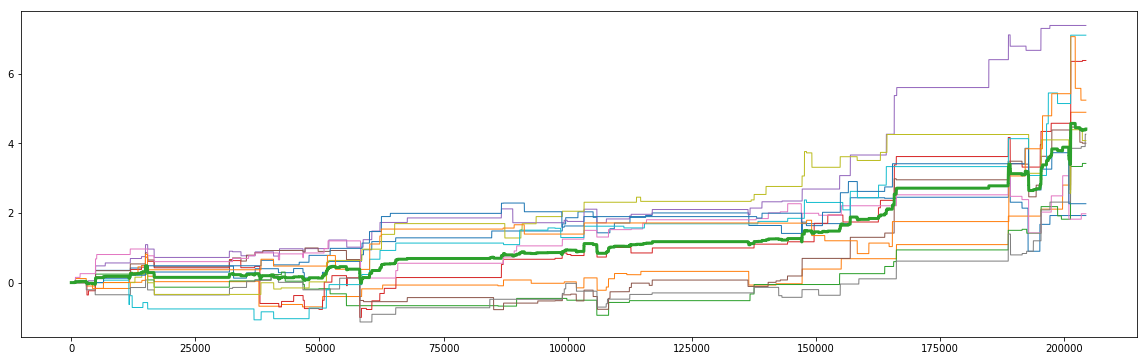

In [130]:
# Отобразим на графике доходности все
plt.rc("figure", figsize=(20, 6))

for i in range(1,ALL_PROFIT_PERC.shape[1]):
#     print(i)
    plt.plot(ALL_PROFIT_PERC.index, ALL_PROFIT_PERC.iloc[:,i], linewidth=1)
    
# Среднее значение
ALL_PROFIT_PERC_MIDD = ALL_PROFIT_PERC.iloc[:, [0]].join(ALL_PROFIT_PERC.iloc[:, 1:].mean(axis=1).rename('SUMM_MIDD'))

plt.plot(ALL_PROFIT_PERC_MIDD.index, ALL_PROFIT_PERC_MIDD.iloc[:,1], linewidth=3)

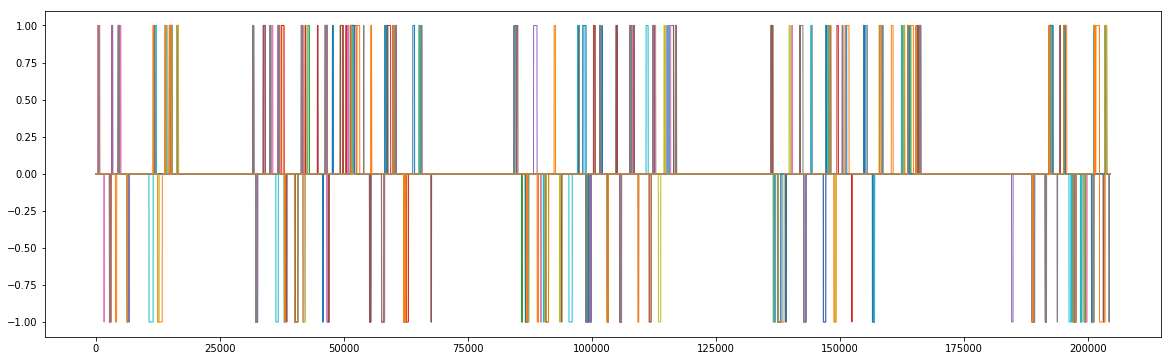

In [134]:
# Отобразим на графике доходности все
plt.rc("figure", figsize=(20, 6))

for i in range(1,TRADES.shape[1]):
#     print(i)
    plt.plot(TRADES.index, TRADES.iloc[:,i], linewidth=1)
    
# Среднее значение
TRADES_SUMM = TRADES.iloc[:, [0]].join(TRADES.iloc[:, 1:].sum(axis=1).rename('SUMM_MIDD'))

# plt.plot(TRADES_SUMM.index, TRADES_SUMM.iloc[:,1], linewidth=1)
TRADES_SUMM.to_csv('TRADES_SUMM.csv', sep=';')

In [127]:
strategies_analyse
# strategy_params
# curr_m
strategies.values[0]
strategies_analyse.strategy.iloc[0]

strategies_analyse.KAMA_PER.values[7]
strategies_analyse.KAMA_PER.iloc[7]
data
# ALL_PROFIT_PERC.shape[1]
# ALL_PROFIT_PERC
# df1 = data[['timestamp','SUMM_PERC']] 
# df1
# TRADES.loc[TRADES.s2_0 == 2, s2_0] = 0

# убираем 2 и -2
for i in range(1,TRADES.shape[1]):
    print(i)
    TRADES.loc[(TRADES.iloc[:,i] == -2) | (TRADES.iloc[:,i] == 2),TRADES.columns.values[i]] = 0
    
TRADES
# TRADES.iloc[:,1:]
# TRADES.iloc[:,1].column
# TRADES.columns.values[1]

1
2
3
4
5
6
7
8
9
10
11
12


,timestamp,s2_0,s2_15,s2_30,s3_0,s3_10,s3_20,s3_30,s3_40,s5_0,s5_15,s5_30,s5_45
0,2019-05-02 10:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-05-02 10:01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-05-02 10:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-05-02 10:03:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-05-02 10:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2019-05-02 10:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2019-05-02 10:06:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2019-05-02 10:07:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2019-05-02 10:08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2019-05-02 10:09:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# ------------------------------НИЖЕ ВСЯКАЯ ОТЛАДКА И ТЕСТЫ ------------------------------------

2.2912551746740935

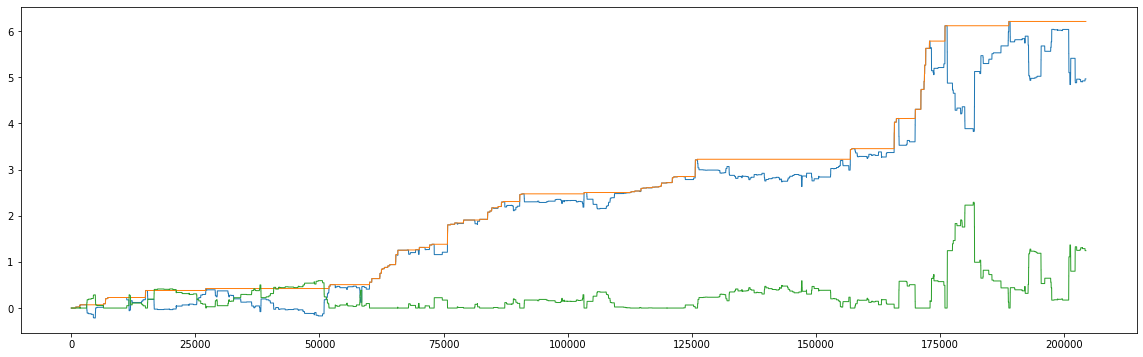

In [8]:
maximum = np.maximum.accumulate(df.iloc[:,1])

draw_down = maximum - df.SUMM_MIDD

max_draw_down = draw_down.max() #Рассчитали максимальную просадку

#Отладка проверка/визуализация работы функции np.maximum.accumulate
plt.rc("figure", figsize=(20, 6))

plt.plot(df.index, df.SUMM_MIDD, linewidth=1)
plt.plot(df.index, maximum, linewidth=1)
plt.plot(df.index, draw_down, linewidth=1)
max_draw_down

In [12]:
maximum

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
25578    21.057852
25579    21.057852
25580    21.057852
25581    21.057852
25582    21.057852
Name: SUMM_MIDD, Length: 25583, dtype: float64

In [56]:
PROFIT_PERC.iloc[:,[0,1]]
# PROFIT_PERC.iloc[:,[0,curr_strategy+1]]

df = pd.merge(df,PROFIT_PERC.iloc[:,[0,1]], how='left', on='timestamp')
df

,timestamp,s0
0,2019-12-10 15:34:00,0.000000
1,2019-12-10 15:35:00,0.000000
2,2019-12-10 15:36:00,0.000000
3,2019-12-10 15:37:00,0.000000
4,2019-12-10 15:38:00,0.000000
...,...,...
25578,2020-04-29 20:04:00,20.431636
25579,2020-04-29 20:05:00,20.431636
25580,2020-04-29 20:06:00,20.431636
25581,2020-04-29 20:07:00,20.431636


In [36]:
df = df.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
df = df.fillna(0) # А все что сначала не заполнилось заливаем нулями    

df

PROFIT_PERC = PROFIT_PERC.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
PROFIT_PERC = PROFIT_PERC.fillna(0) # А все что сначала не заполнилось заливаем нулями 
PROFIT_PERC


,timestamp,0,1,2
0,2019-12-10 15:34:00,0.000000,0.000000,0.000000
1,2019-12-10 15:35:00,0.000000,0.000000,0.000000
2,2019-12-10 15:36:00,0.000000,0.000000,0.000000
3,2019-12-10 15:37:00,0.000000,0.000000,0.000000
4,2019-12-10 15:38:00,0.000000,0.000000,0.000000
...,...,...,...,...
25578,2020-04-29 20:04:00,20.431636,0.115052,-0.958543
25579,2020-04-29 20:05:00,20.431636,0.115052,-0.958543
25580,2020-04-29 20:06:00,20.431636,0.115052,-0.958543
25581,2020-04-29 20:07:00,20.431636,0.115052,-0.958543


In [8]:
# Посчитаем средне в столбце
# df.iloc[[1,-1]].mean(axis=1)

# df = df.iloc[:, [0]].join(df.iloc[:, 1:].sum(axis=1).rename('Z'))
df = df.iloc[:, [0]].join(df.iloc[:, 1:].mean(axis=1).rename('SUMM_MIDD'))
df


,timestamp,SUMM_MIDD
0,2019-12-10 15:34:00,0.000000
1,2019-12-10 15:35:00,0.000000
2,2019-12-10 15:36:00,0.000000
3,2019-12-10 15:37:00,0.000000
4,2019-12-10 15:38:00,0.000000
...,...,...
25578,2020-04-29 20:04:00,2.662246
25579,2020-04-29 20:05:00,2.662246
25580,2020-04-29 20:06:00,2.662246
25581,2020-04-29 20:07:00,2.662246


In [9]:
df = df[['timestamp']] 
df

,timestamp
0,2019-12-10 15:34:00
1,2019-12-10 15:35:00
2,2019-12-10 15:36:00
3,2019-12-10 15:37:00
4,2019-12-10 15:38:00
...,...
25578,2020-04-29 20:04:00
25579,2020-04-29 20:05:00
25580,2020-04-29 20:06:00
25581,2020-04-29 20:07:00


In [16]:
#  -------- Отладка суммирования столбцов
# получили data из стратегии, далее в соответствии с timestamp и BUY заносим столбец BUY в наш расчетно-ценофой датафрейм curr_m
# Перед этим, оставим в data только те столбцы, которые нам нужны.
# data = data.loc[:, ['timestamp','BUY','SUMM_PIP','SUMM_PERC']]
# В левый(curr_m) датафрейм кидаем все что в правом по ключу 'timestamp'
# curr_m = pd.merge(curr_m,data, how='left', on='timestamp') 


df = curr_m.copy(deep=False)

df.index = df['timestamp']
df.drop(['timestamp','open','high','low','close','vol'], axis=1, inplace=True)
df.reset_index(inplace=True) #Сброс индексов и timestamp уже не будет индексом 


df1 = data[['timestamp','SUMM_PERC']]

# df1 = df[['a','b']]
df1
df = pd.merge(df,df1, how='left', on='timestamp')

df = df.fillna(method='ffill') # Заполняем дыры предыдущим действительным значением
df = df.fillna(0) # А все что сначала не заполнилось заливаем нулями    

df1.rename(columns={'SUMM_PERC': 'XUY'+'1'}, inplace=True)
df1

,timestamp,XUY1
1,2019-12-10 17:46:00,0.000000
30,2019-12-12 20:06:00,0.000000
34,2019-12-13 10:16:00,0.456374
39,2019-12-13 15:21:00,0.456374
42,2019-12-13 18:21:00,0.142854
145,2019-12-25 19:03:00,0.142854
148,2019-12-25 22:03:00,0.107663
164,2019-12-27 10:48:00,0.107663
169,2019-12-27 15:53:00,-0.117314
257,2020-01-10 23:13:00,-0.117314


In [42]:
 tst, data = elder_macd_profit(curr_h, 0, 20, 30, 3, 1, 3, 5, 1.3, 0.5, 100, 0.5)
data.DEV.values[-1]
data.DEV
data.DEV.values[-1]

40.50290076602735